In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# 1️⃣ Charger les données
df = pd.read_csv("../data/hateXplain_cleaned.csv")
df = df[['cleaned_text', 'label']].dropna()
df = df[df['label'].isin(['offensive', 'hatespeech', 'normal'])]

X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_text'], df['label'], test_size=0.15, random_state=42, stratify=df['label']
)

In [3]:
# 2️⃣ TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=15000, ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [4]:
# 3️⃣ Modèle 1 : Logistic Regression
clf_lr = LogisticRegression(max_iter=2000, class_weight='balanced')
clf_lr.fit(X_train_vec, y_train)
y_pred_lr = clf_lr.predict(X_test_vec)

In [5]:
# 4️⃣ Modèle 2 : SVM
clf_svm = LinearSVC(class_weight='balanced', max_iter=5000)
clf_svm.fit(X_train_vec, y_train)
y_pred_svm = clf_svm.predict(X_test_vec)


Partie 5 : Étude comparative des prédictions

On peut comparer les deux modèles avec :

Classification report (précision, rappel, F1-score)

Matrice de confusion pour visualiser les erreurs de classification

=== Logistic Regression ===
              precision    recall  f1-score   support

  hatespeech       0.74      0.73      0.73      2897
      normal       0.52      0.65      0.58      1652
   offensive       0.59      0.51      0.54      2689

    accuracy                           0.63      7238
   macro avg       0.62      0.63      0.62      7238
weighted avg       0.63      0.63      0.63      7238

=== SVM ===
              precision    recall  f1-score   support

  hatespeech       0.72      0.74      0.73      2897
      normal       0.54      0.58      0.56      1652
   offensive       0.58      0.54      0.56      2689

    accuracy                           0.63      7238
   macro avg       0.61      0.62      0.61      7238
weighted avg       0.63      0.63      0.63      7238



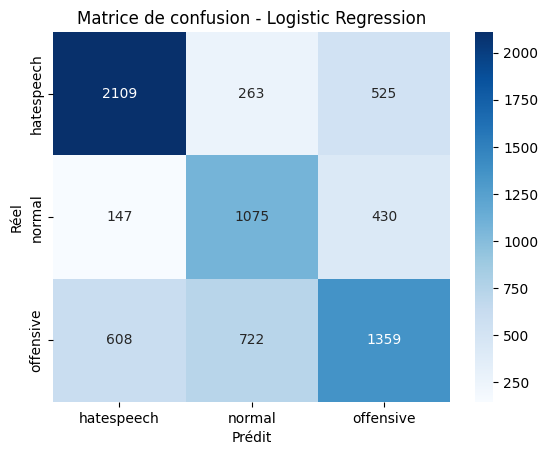

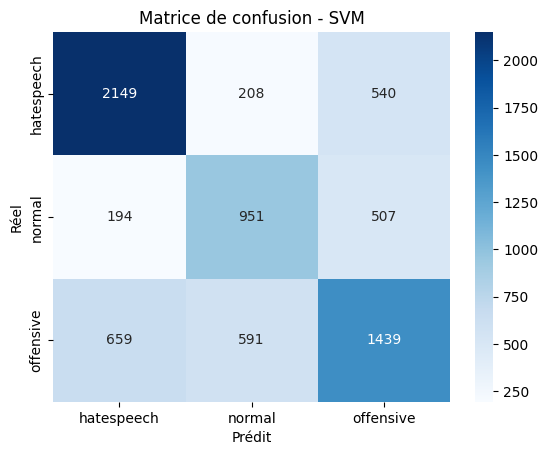

In [17]:
print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))

print("=== SVM ===")
print(classification_report(y_test, y_pred_svm))

# Matrices de confusion
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=['hatespeech','normal','offensive'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['hatespeech','normal','offensive'], yticklabels=['hatespeech','normal','offensive'])
    plt.xlabel('Prédit')
    plt.ylabel('Réel')
    plt.title(title)
    plt.show()

plot_confusion(y_test, y_pred_lr, "Matrice de confusion - Logistic Regression")
plot_confusion(y_test, y_pred_svm, "Matrice de confusion - SVM")


Partie 6 : Visualisation des résultats

Quelques idées de visualisation pour mieux comprendre les facteurs influençant le harcèlement social :

Distribution des classes prédites vs réelles

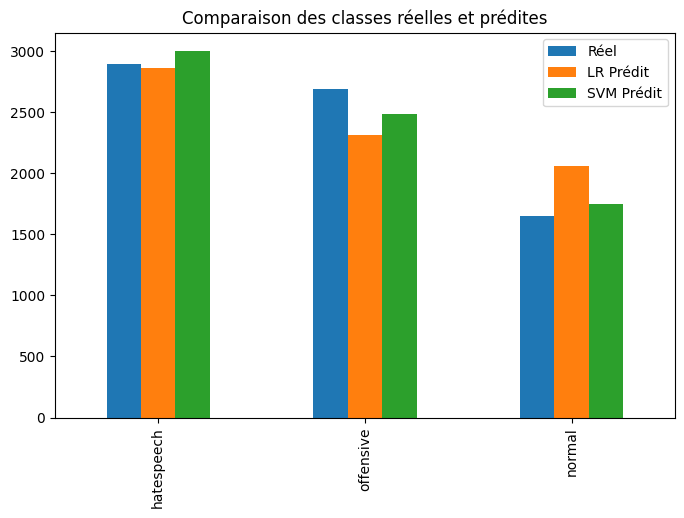

In [7]:
import matplotlib.pyplot as plt

pd.DataFrame({
    "Réel": y_test.value_counts(),
    "LR Prédit": pd.Series(y_pred_lr).value_counts(),
    "SVM Prédit": pd.Series(y_pred_svm).value_counts()
}).plot(kind='bar', figsize=(8,5))
plt.title("Comparaison des classes réelles et prédites")
plt.show()


In [8]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


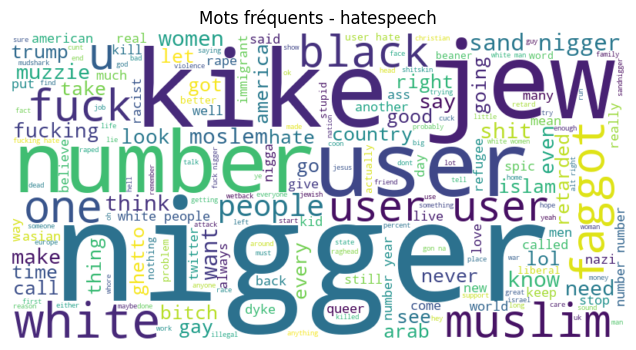

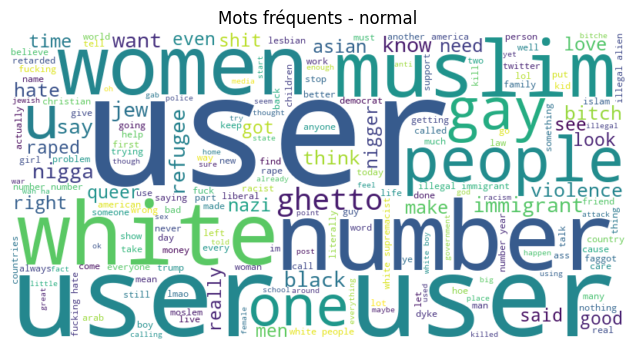

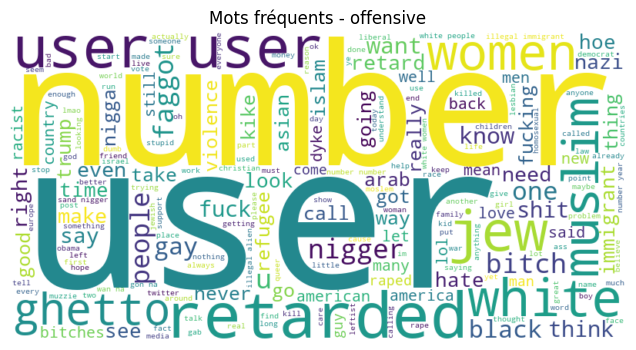

In [9]:
from wordcloud import WordCloud

for label in ['hatespeech','normal','offensive']:
    text = " ".join(df[df['label']==label]['cleaned_text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Mots fréquents - {label}")
    plt.show()


## test


In [10]:
texts = [
    "I hate this person, they are awful!", 
    "Have a nice day everyone!", 
    "You are stupid and useless"
]
texts_vec = vectorizer.transform(texts)
preds_lr = clf_lr.predict(texts_vec)
for t, p in zip(texts, preds_lr):
    print(f"[Logistic Regression] Texte: {t} --> Prédiction: {p}")
preds_svm = clf_svm.predict(texts_vec)
for t, p in zip(texts, preds_svm):
    print(f"[SVM] Texte: {t} --> Prédiction: {p}")


[Logistic Regression] Texte: I hate this person, they are awful! --> Prédiction: offensive
[Logistic Regression] Texte: Have a nice day everyone! --> Prédiction: offensive
[Logistic Regression] Texte: You are stupid and useless --> Prédiction: hatespeech
[SVM] Texte: I hate this person, they are awful! --> Prédiction: offensive
[SVM] Texte: Have a nice day everyone! --> Prédiction: offensive
[SVM] Texte: You are stupid and useless --> Prédiction: normal


# Justification du choix des modèles

Pour identifier les messages de harcèlement social, nous avons choisi d’utiliser deux modèles linéaires classiques : **Logistic Regression (LR)** et **Support Vector Machine (SVM)**.

- **Logistic Regression** a été sélectionnée pour sa **simplicité** et sa **rapidité** d’entraînement sur des vecteurs TF-IDF, ainsi que pour sa capacité à fournir des **probabilités interprétables** pour chaque classe. Elle sert de **baseline solide** pour évaluer les performances des modèles plus complexes.

- **SVM** a été choisi pour sa **robustesse dans la séparation des classes** et sa capacité à gérer les **déséquilibres entre classes** grâce au paramètre `class_weight='balanced'`. Il est souvent performant sur les tâches de classification de texte et permet de vérifier si une séparation stricte des classes améliore la détection des messages offensifs ou haineux.

L’utilisation des deux modèles permet de **comparer des approches différentes** et d’établir une **référence fiable** avant de passer à des modèles plus complexes comme **LightGBM** ou les modèles **Transformers**. Cette approche s’inscrit dans une démarche progressive d’**optimisation de la performance de classification**.
